# Corporación Favorita Grocery Sales Forecasting - Data Exploration

### _Based on data from https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data_

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(purrr))

setwd("")

<p style="text-align: center; color:green; font-size: 180%; font-weight: bold">Part 1. Study of tables with support data - stores and items</p>

In [2]:
# Function to check structure of dataset's support tables based on different criteria
# df - Data.Frame object
# col_name - str variable - name of column to summarise table by
# tag - str variable - set custom name for the second column of the output table

count_by <- function(df, col_name, tag = "num") {
  counted <- df %>% group_by(df$col_name) %>% summarise(count = n()) %>% arrange(desc(count))
  names(counted) <- c(col_name, tag)
  return(counted)
}

<p style="text-align: center; color:green; font-size: 150%; font-weight: bold">Stores</p>

In [3]:
stores <- read.csv("stores.csv", stringsAsFactors = FALSE)
#stores <- select(stores, -store_nbr)

head(stores)

store_nbr,city,state,type,cluster
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
6,Quito,Pichincha,D,13


In [4]:
summarise_by_1 <- list("city", "type", "state", "cluster")

summarised_1 <- pmap(list(df = lapply(1:4, function(x) stores), 
                        col_name = summarise_by_1), 
                          count_by)
    
names(summarised_1) <- paste0("by_", summarise_by_1)
    
summarised_1$by_state

state,num
Pichincha,19
Guayas,11
Azuay,3
Manabi,3
Santo Domingo de los Tsachilas,3
Cotopaxi,2
El Oro,2
Los Rios,2
Tungurahua,2
Bolivar,1


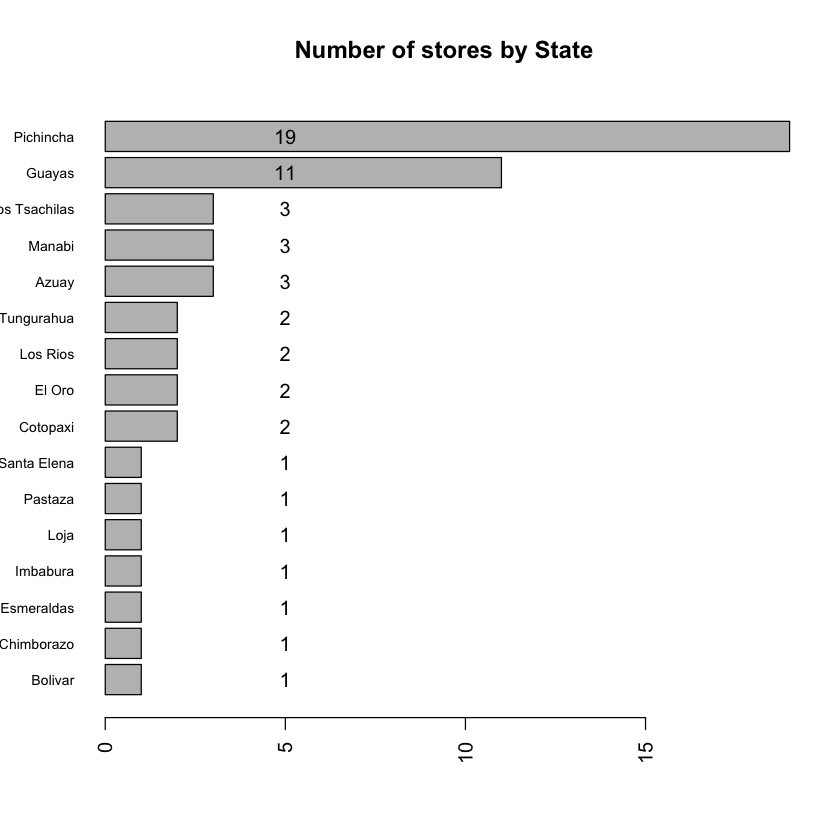

In [5]:
mids_1 <- barplot(sort(table(stores$state)), horiz = TRUE, las = 2, cex.names = 0.7, main = "Number of stores by State")
text(5, mids_1, as.numeric(sort(table(stores$state))))

<p style="text-align: center; color:green; font-size: 150%; font-weight: bold">Items</p>

In [6]:
items <- read.csv("items.csv", stringsAsFactors = FALSE)
head(items)

item_nbr,family,class,perishable
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103501,CLEANING,3008,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1
105574,GROCERY I,1045,0


In [7]:
summarise_by_2 <- list("family", "class", "perishable")

summarised_2 <- pmap(list(df = lapply(1:3, function(x) items), 
                        col_name = summarise_by_2), 
                          count_by)
    
names(summarised_2) <- paste0("by_", summarise_by_2)
    
(family_top10 <- summarised_2$by_family[1:10,])

family,num
GROCERY I,1334
BEVERAGES,613
CLEANING,446
PRODUCE,306
DAIRY,242
PERSONAL CARE,153
BREAD/BAKERY,134
HOME CARE,108
DELI,91
MEATS,84


In [8]:
family_index <- which(items$family %in% family_top10$family)
family_top_tbl <- sort(table(items$family[family_index]))

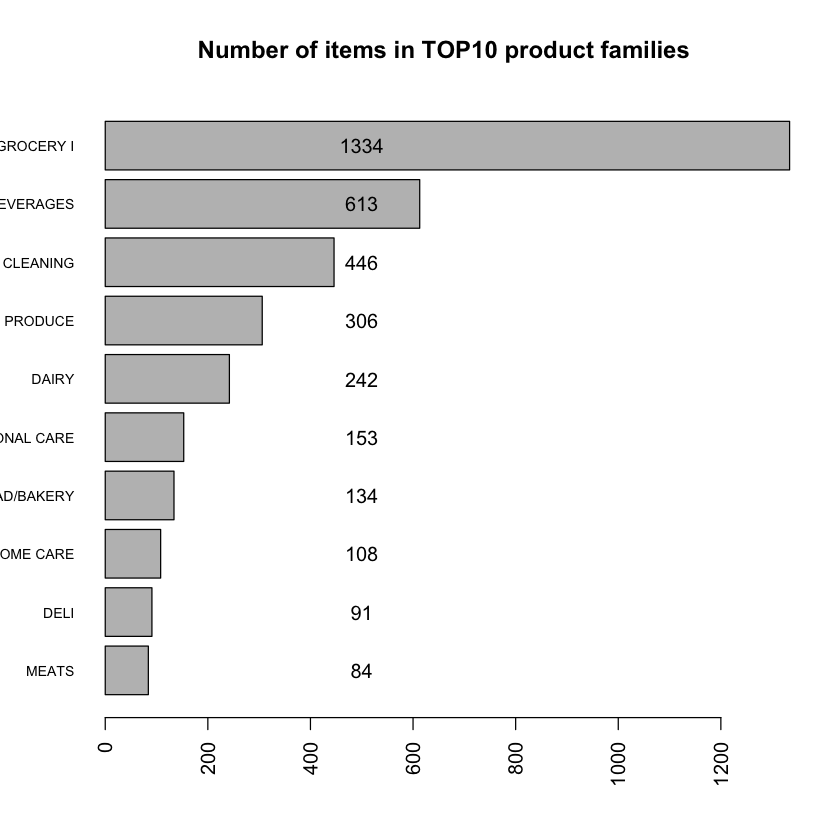

In [9]:
mids_2 <- barplot(family_top_tbl, horiz = TRUE, las = 2, cex.names = 0.7, main = "Number of items in TOP10 product families")
text(500, mids_2, as.numeric(family_top_tbl))

<p style="text-align: center; color:blue; font-size: 180%; font-weight: bold">Part 2. Study of train data with PostgreSQL</p>

In [10]:
library(RPostgreSQL)

pw <- {""}
drv <- dbDriver("PostgreSQL")
con <- dbConnect(drv, dbname = "DB_CF_Sales", 
                 host = "localhost", port = 5432,
                 user = "postgres", password = pw)

dbExistsTable(con, "sales")

Loading required package: DBI


[1] TRUE

In [11]:
#Test tables/joins
(example_mapped <- dbGetQuery(con, 
                             "SELECT s.date_sale, s.store_num, s.item_num, st.city, i.item_family
                              FROM sales AS s
                              INNER JOIN stores AS st
                              ON s.store_num = st.id_store
                              INNER JOIN items as i
                              ON s.item_num = i.item_id
                              LIMIT 5"))

date_sale,store_num,item_num,city,item_family
2013-01-01,25,103665,Salinas,BREAD/BAKERY
2013-01-01,25,105574,Salinas,GROCERY I
2013-01-01,25,105575,Salinas,GROCERY I
2013-01-01,25,108079,Salinas,GROCERY I
2013-01-01,25,108701,Salinas,DELI


In [12]:
(num_lines <- dbGetQuery(con, 
                             "SELECT COUNT(*)
                              FROM sales"))

#num_lines 125 497 040

count
125497040


In [13]:
#check if a store has full assortment in terms of item family. Executes in ~8 min on my PC
store_assortment <- dbGetQuery(con, 
                             "SELECT s.store_num, COUNT(DISTINCT(i.item_family))
                              FROM sales AS s
                              INNER JOIN stores AS st
                              ON s.store_num = st.id_store
                              INNER JOIN items as i
                              ON s.item_num = i.item_id
                              GROUP BY s.store_num")
head(store_assortment)

store_num,count
1,32
2,33
3,33
4,33
5,33
6,33


In [14]:
#store assortment for each store by item family. Executes in ~2 min on my PC
store_assortment_details <- dbGetQuery(con, 
                               "SELECT DISTINCT st.id_store, i.item_family
                                FROM sales
                                INNER JOIN stores AS st
                                ON sales.store_num = st.id_store
                                INNER JOIN items AS i
                                ON sales.item_num = i.item_id
                                ORDER BY st.id_store ASC")


In [15]:
#Find what item families are missing in each store
lookup <- expand.grid(id_store = 1:54, item_family = unique(store_assortment_details$item_family))

lookup %>%
    anti_join(store_assortment_details, by = c("id_store", "item_family")) %>%
    arrange(id_store)

id_store,item_family
1,BABY CARE
9,BOOKS
10,BOOKS
11,BOOKS
12,BOOKS
13,BABY CARE
13,BOOKS
14,LAWN AND GARDEN
14,BOOKS
15,BOOKS
